In [ ]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)
%cd /gdrive/My Drive/TESI MATTEO IV

Mounted at /gdrive
/gdrive/My Drive/TESI MATTEO IV


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch

In [ ]:
import os
os.listdir()

['mimicIV_24h_diagnoses.csv',
 'mimicIV_24h_procedures.csv',
 'Embeddings Diagnoses Procedures',
 '24h_Procedures_embeddings.pkl',
 '90pca_transformed_embeddings_procedures.pkl',
 'mimicIV_24h_comorbidities.csv',
 '24h_Diagnoses_embeddings.pkl',
 '90pca_transformed_embeddings_diagnoses.pkl',
 'Prediction',
 'mimicIV_24h_complete_blood.csv',
 'mimicIV_24h_complete_lab.csv',
 'mimicIV_24h_complete_art.csv',
 'mimicIV_24h_prescriptions.csv',
 '24h_1MedicalPrescription_embeddings.pkl',
 '24h_4MedicalPrescription_embeddings.pkl',
 '24h_3MedicalPrescription_embeddings.pkl',
 '90pca_transformed_embeddings_prescription.pkl',
 '24h_2MedicalPrescription_embeddings.pkl',
 'mimicIV_24h_complete_demo.csv',
 'mimicIV_24h_additional.csv']

In [ ]:
df_diagnoses = pd.read_csv('mimicIV_24h_diagnoses.csv')
print(f"df shape: {df_diagnoses.shape}")

df shape: (820300, 7)


In [ ]:
df_diagnoses.head()

,subject_id,hadm_id,stay_id,icu_admission_time,icd_code,icd_version,diagnosis_description
0,10000032,29079034,39553978,2180-07-23 14:00:00,45829,9.0,Other iatrogenic hypotension
1,10000032,29079034,39553978,2180-07-23 14:00:00,07044,9.0,Chronic hepatitis C with hepatic coma
2,10000032,29079034,39553978,2180-07-23 14:00:00,7994,9.0,Cachexia
3,10000032,29079034,39553978,2180-07-23 14:00:00,2761,9.0,Hyposmolality and/or hyponatremia
4,10000032,29079034,39553978,2180-07-23 14:00:00,78959,9.0,Other ascites


### COMPLETE ANALYSIS (remove nan values)

In [ ]:
# Filter out any rows that have at least one missing value
df_diagnoses = df_diagnoses.dropna()

print("Shape of DataFrame with complete cases:", df_diagnoses.shape)
df_diagnoses.head()

Shape of DataFrame with complete cases: (820281, 7)


,subject_id,hadm_id,stay_id,icu_admission_time,icd_code,icd_version,diagnosis_description
0,10000032,29079034,39553978,2180-07-23 14:00:00,45829,9.0,Other iatrogenic hypotension
1,10000032,29079034,39553978,2180-07-23 14:00:00,07044,9.0,Chronic hepatitis C with hepatic coma
2,10000032,29079034,39553978,2180-07-23 14:00:00,7994,9.0,Cachexia
3,10000032,29079034,39553978,2180-07-23 14:00:00,2761,9.0,Hyposmolality and/or hyponatremia
4,10000032,29079034,39553978,2180-07-23 14:00:00,78959,9.0,Other ascites


In [ ]:
df_diagnoses.loc[(df_diagnoses.icd_code == 'I6782')].shape

(21, 7)

### CONCATENATE LONG DIAGNOSES/PROCEDURES BY ICUSTAY_ID

In [ ]:
# Group by 'icustay_id' and concatenate the 'long_title' for each group
df_diagnoses_grouped = df_diagnoses.groupby('stay_id')['diagnosis_description'].agg(lambda titles: '; '.join(titles)).reset_index()
print(df_diagnoses_grouped.shape)
df_diagnoses_grouped.head()

(50540, 2)


,stay_id,diagnosis_description
0,30000153,Subdural hemorrhage following injury without m...
1,30000213,Hypertensive heart and chronic kidney disease ...
2,30000484,"Unspecified septicemia; Pneumonia, organism un..."
3,30001148,Coronary atherosclerosis of native coronary ar...
4,30001336,ST elevation (STEMI) myocardial infarction inv...


### EMBEDDINGS

In [ ]:
import time
from transformers import AutoTokenizer, AutoModel

def load_model_with_retry(model_name, retries=5):
    for i in range(retries):
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModel.from_pretrained(model_name)
            return tokenizer, model
        except Exception as e:
            wait = 2 ** i
            print(f"Attempt {i+1} failed with error {e}. Retrying in {wait} seconds.")
            time.sleep(wait)
    raise Exception("Failed to load model after several retries.")

# Usage
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer, model = load_model_with_retry(model_name)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# Find the maximum length of the tokens
df = df_diagnoses_grouped.copy()
tokenizer_test = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenizing and analyzing lengths
df['token_length'] = df['diagnosis_description'].apply(lambda x: len(tokenizer_test.tokenize(x)))

# Descriptive statistics for suggested max_length
stats = df['token_length'].describe(percentiles=[.95])
max_length_suggested = int(stats['95%'])

# Maximum token length for understanding the upper bound
max_length_maximum = df['token_length'].max()

print("Suggested max_length based on 95th percentile:", max_length_suggested)
print("Maximum token length in the dataset:", max_length_maximum)

Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


Suggested max_length based on 95th percentile: 330
Maximum token length in the dataset: 572


In [ ]:
def generate_embeddings(df, text_column, tokenizer, model):
    embeddings_dict = {}
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating Embeddings"):
        text = row[text_column]
        icustay_id = row['stay_id']
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :].numpy().squeeze()
        embeddings_dict[icustay_id] = embedding

    return embeddings_dict

In [ ]:
import pickle

In [ ]:
diagnoses_embeddings_admissions = generate_embeddings(df_diagnoses_grouped, 'diagnosis_description', tokenizer, model)

# Save the PCA-transformed embeddings to a file
Diagnoses_embeddings_file = '/gdrive/My Drive/TESI MATTEO IV/24h_Diagnoses_embeddings.pkl'

with open(Diagnoses_embeddings_file, 'wb') as file:
    pickle.dump(diagnoses_embeddings_admissions, file)

Generating Embeddings: 100%|██████████| 50540/50540 [3:05:07<00:00,  4.55it/s]


### IMPORT EMBEDDINGS

In [ ]:
# Define the paths to the embeddings files for each subgroup
subgroup_files = [
    '/gdrive/My Drive/TESI MATTEO IV/24h_Diagnoses_embeddings.pkl'
]

# Initialize an empty dictionary to hold all embeddings
all_embeddings = {}

# Load each file and merge the dictionaries
for file_path in subgroup_files:
    with open(file_path, 'rb') as file:
        embeddings = pickle.load(file)
        all_embeddings.update(embeddings)

df_procedures_grouped = pd.DataFrame(list(all_embeddings.items()), columns=['stay_id', 'Embeddings'])

# Display the head of the DataFrame to verify
print(df_procedures_grouped.shape)
df_procedures_grouped.head()

(50540, 2)


,stay_id,Embeddings
0,30000153,"[0.055216346, 0.07852602, -0.32425928, 0.14874..."
1,30000213,"[-0.042923637, -0.12765323, -0.4834769, 0.2805..."
2,30000484,"[0.10458737, -0.22760755, -0.1583999, 0.345331..."
3,30001148,"[0.08230162, -0.1562352, -0.38145322, 0.290666..."
4,30001336,"[0.16675289, -0.08141287, -0.46072182, 0.26925..."


### COMBINE EMBEDDINGS

In [ ]:
# Drop duplicates based on 'ICUSTAY_ID'
df_procedures_grouped = df_procedures_grouped.drop_duplicates(subset='stay_id')

# Ensure each embedding is actually a numpy array and stack them vertically
embeddings_list = df_procedures_grouped['Embeddings'].tolist()
icustay_ids = df_procedures_grouped['stay_id'].values
combined_embeddings_matrix = np.vstack(embeddings_list)

# Verify the shape
print("Shape of combined embeddings matrix:", combined_embeddings_matrix.shape)

Shape of combined embeddings matrix: (50540, 768)


### STANDARDIZATION

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scale the data prior to applying PCA
scaler = StandardScaler()
combined_embeddings_matrix_standardized = scaler.fit_transform(combined_embeddings_matrix)

### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

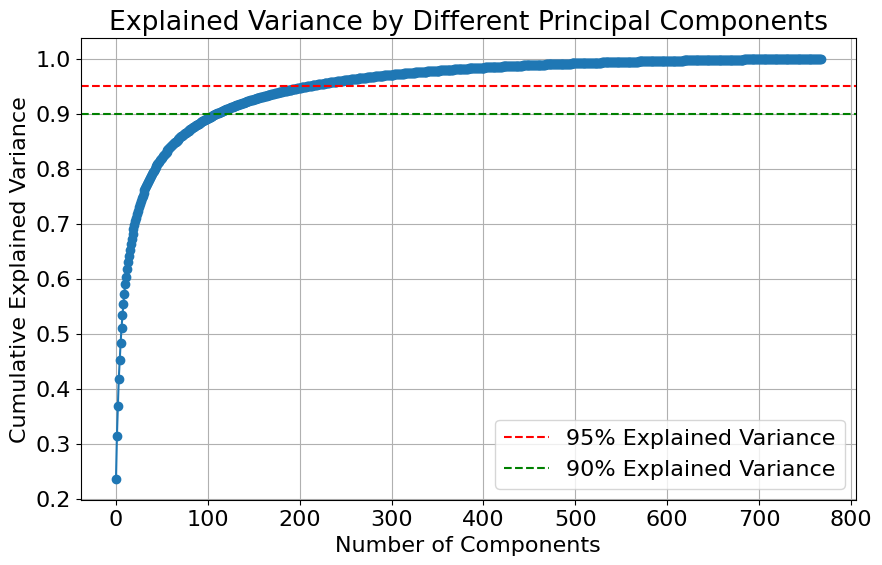

Number of components to explain 95% variance: 211
Number of components to explain 90% variance: 111


In [ ]:
pca = PCA().fit(combined_embeddings_matrix_standardized)

explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Find the number of components for 95% and 90% of explained variance
components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
components_90 = np.where(cumulative_variance >= 0.90)[0][0] + 1

print(f"Number of components to explain 95% variance: {components_95}")
print(f"Number of components to explain 90% variance: {components_90}")

In [ ]:
# Apply PCA with the optimal number of components found earlier
pca = PCA(n_components=components_90)
pca_transformed = pca.fit_transform(combined_embeddings_matrix_standardized)
pca_reconstructed = pca.inverse_transform(pca_transformed)

# Calculate MSE for PCA
pca_mse = mean_squared_error(combined_embeddings_matrix_standardized, pca_reconstructed)
print("PCA MSE:", pca_mse)

PCA MSE: 0.1000944


In [ ]:
# Combine PCA results back with ICUSTAY_ID
df_pca_transformed = pd.DataFrame(pca_transformed)
df_pca_transformed['stay_id'] = icustay_ids

# Verify structure
print(df_pca_transformed.head())

           0          1         2         3         4         5         6  \
0   1.267105  18.319292  6.618798  3.066200 -4.907320  3.912782 -6.997460   
1 -14.104289 -12.457269  1.547655 -4.277471 -3.680568 -0.016878 -0.229884   
2   3.049127  -3.583543  4.055541  5.649945  9.746267 -3.187482 -4.050682   
3  16.339224 -10.864053  5.840961  6.725543  0.719166  2.263074  1.505821   
4  -2.852499  -7.014249 -1.978446  3.078453  3.457377 -0.715461 -5.768764   

          7         8         9  ...       102       103       104       105  \
0  1.248653 -0.088293  0.405796  ... -0.571129 -1.293869 -0.799014  0.427277   
1 -0.535758  6.842532  1.942750  ... -0.868348  0.312928  0.380380 -0.181335   
2 -7.245343  1.380771 -2.037564  ...  1.699215  0.367069  0.760328 -0.270046   
3  3.940609 -0.590859 -0.828817  ... -0.045981  0.531674 -0.000169 -1.326605   
4  4.550480 -0.763300  1.584656  ...  0.166992 -1.248489  1.579645 -0.876829   

        106       107       108       109       110   st

In [ ]:
# Save the PCA-transformed embeddings to a file
pca_embeddings_file = '/gdrive/My Drive/TESI MATTEO IV/90pca_transformed_embeddings_diagnoses.pkl'

with open(pca_embeddings_file, 'wb') as file:
    pickle.dump(df_pca_transformed, file)